https://www.ers.usda.gov/data-products/food-security-in-the-united-states

https://www.ers.usda.gov/topics/food-nutrition-assistance/food-security-in-the-us/interactive-charts-and-highlights

https://cps.ipums.org/cps/index.shtml

In [56]:
# import pandas as pd

# df = pd.read_csv("cps_00003.csv")
# df.to_parquet("cps_raw.parquet")

In [57]:
import pandas as pd
import pyarrow

df = pd.read_parquet("cps_raw.parquet")
df.head()


,YEAR,SERIAL,MONTH,HWTFINL,CPSID,STATEFIP,STATECENSUS,FAMINC,FSSTATUS,FSRAWSCR,...,WTFINL,CPSIDP,CPSIDV,AGE,SEX,RACE,MARST,FAMUNIT,HISPAN,EDUC
0,2014,3,12,1611.1985,20140900000100,1,63,430,1,0,...,1611.1985,20140900000101,201409000001011,66,1,100,4,1,0,71
1,2014,5,12,1407.9655,20141000000600,1,63,710,1,1,...,1407.9655,20141000000601,201410000006011,65,2,200,5,1,0,60
2,2014,5,12,1407.9655,20141000000600,1,63,710,1,1,...,1407.9655,20141000000602,201410000006021,80,2,200,5,1,0,50
3,2014,6,12,2378.1267,20140900000900,1,63,710,1,0,...,2378.1267,20140900000901,201409000009011,25,2,100,6,1,0,73
4,2014,6,12,2378.1267,20140900000900,1,63,710,1,0,...,1938.2656,20140900000902,201409000009021,2,2,100,9,1,0,1


In [58]:
dict_path = "data_dictionary.txt"

value_labels = {}
current_var = None

with open(dict_path, "r") as f:
    for raw in f:
        line = raw.rstrip()
        stripped = line.strip()
        if not stripped:
            continue

        parts = stripped.split()
        first = parts[0]

        # Variable header: ALL CAPS, alphabetic, not MONTH/STATEFIP header area
        if first.isalpha() and first.isupper() and len(parts) > 1:
            current_var = first
            value_labels.setdefault(current_var, {})
            continue

        # Code line: starts with digit
        if first[0].isdigit() and current_var is not None:
            try:
                code = int(first)
            except:
                continue
            label = " ".join(parts[1:])
            value_labels[current_var][code] = label


We only want variables for which:
 - The CSV contains the column, and
 - The dictionary contains at least one code mapping

In [59]:
cols_to_map = [
    col for col in df.columns
    if col in value_labels and len(value_labels[col]) > 0
]

cols_to_map


['MONTH',
 'STATEFIP',
 'STATECENSUS',
 'FAMINC',
 'FSSTATUS',
 'FSRAWSCR',
 'FSSTATUSD',
 'FSRAWSCRA',
 'FSRAWSCRC',
 'FSRAWSCRM',
 'FSRAWSCRMA',
 'FSPOOR',
 'FSSKIPMOCAT',
 'AGE',
 'SEX',
 'RACE',
 'MARST',
 'FAMUNIT',
 'HISPAN',
 'EDUC']

Replace every numeric value with its matching text label:


In [60]:
df_labeled = df.copy()

for col in cols_to_map:
    mapping = value_labels[col]
    df_labeled[col] = df_labeled[col].map(mapping).fillna(df_labeled[col])


In [61]:
df_labeled

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,STATEFIP,STATECENSUS,FAMINC,FSSTATUS,FSRAWSCR,...,WTFINL,CPSIDP,CPSIDV,AGE,SEX,RACE,MARST,FAMUNIT,HISPAN,EDUC
0,2014,3,December,1611.1985,20140900000100,Alabama,Alabama,"$10,000 - 12,499",Food secure,No Affirmative Responses or Did Not Pass Initi...,...,1611.1985,20140900000101,201409000001011,66,Male,White,Divorced,1st family in household or group quarters,Not Hispanic,"12th grade, no diploma"
1,2014,5,December,1407.9655,20141000000600,Alabama,Alabama,"$25,000 - 29,999",Food secure,1,...,1407.9655,20141000000601,201410000006011,65,Female,Black,Widowed,1st family in household or group quarters,Not Hispanic,Grade 11
2,2014,5,December,1407.9655,20141000000600,Alabama,Alabama,"$25,000 - 29,999",Food secure,1,...,1407.9655,20141000000602,201410000006021,80,Female,Black,Widowed,1st family in household or group quarters,Not Hispanic,Grade 10
3,2014,6,December,2378.1267,20140900000900,Alabama,Alabama,"$25,000 - 29,999",Food secure,No Affirmative Responses or Did Not Pass Initi...,...,2378.1267,20140900000901,201409000009011,25,Female,White,Never married/single,1st family in household or group quarters,Not Hispanic,High school diploma or equivalent
4,2014,6,December,2378.1267,20140900000900,Alabama,Alabama,"$25,000 - 29,999",Food secure,No Affirmative Responses or Did Not Pass Initi...,...,1938.2656,20140900000902,201409000009021,2,Female,White,NIU,1st family in household or group quarters,Not Hispanic,NIU or blank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164622,2023,69522,December,283.8750,20220906797600,Wyoming,Wyoming,"$35,000 - 39,999",NIU,NIU,...,457.5986,20220906797602,202209067976021,44,Male,White,"Married, spouse present",1st family in household or group quarters,Not Hispanic,Grade 9
1164623,2023,69522,December,283.8750,20220906797600,Wyoming,Wyoming,"$35,000 - 39,999",NIU,NIU,...,545.3707,20220906797603,202209067976031,22,Female,White,Never married/single,1st family in household or group quarters,Not Hispanic,High school diploma or equivalent
1164624,2023,69526,December,397.4895,20220906765500,Wyoming,Wyoming,"$25,000 - 29,999",Very low food secure,7,...,397.4895,20220906765501,202209067655011,42,Female,White,Never married/single,1st family in household or group quarters,Not Hispanic,High school diploma or equivalent
1164625,2023,69529,December,367.3682,20220906822000,Wyoming,Wyoming,"$75,000 - 99,999",Food secure,No Affirmative Responses or Did Not Pass Initi...,...,367.3682,20220906822001,202209068220011,58,Male,White,Divorced,1st family in household or group quarters,Not Hispanic,Bachelor's degree


In [62]:
df_labeled['MONTH'].unique()

array(['December'], dtype=object)

## Food Security Status Across States

In [63]:
import matplotlib.pyplot as plt

# Copy to avoid side effects
df_plot = df_labeled.copy()

# Map FSSTATUS text to a binary category
status_map = {
    "Food secure": "Secure",
    "Low food secure": "Insecure",
    "Very low food secure": "Insecure"
}

df_plot["fs_binary"] = df_plot["FSSTATUS"].map(status_map)

# Drop rows where FSSTATUS is missing or NIU
df_plot = df_plot[df_plot["fs_binary"].notna()]


In [64]:
# Optional: keep only single states (no hyphen)
df_plot = df_plot[~df_plot["STATECENSUS"].str.contains("-")]

state_order = sorted(df_plot["STATECENSUS"].dropna().unique())


In [65]:
# Count by state and binary status
counts = (
    df_plot
    .groupby(["STATECENSUS", "fs_binary"])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions within each state
props = counts.div(counts.sum(axis=1), axis=0)

props_sorted = props.sort_values(by="Insecure", ascending=False)

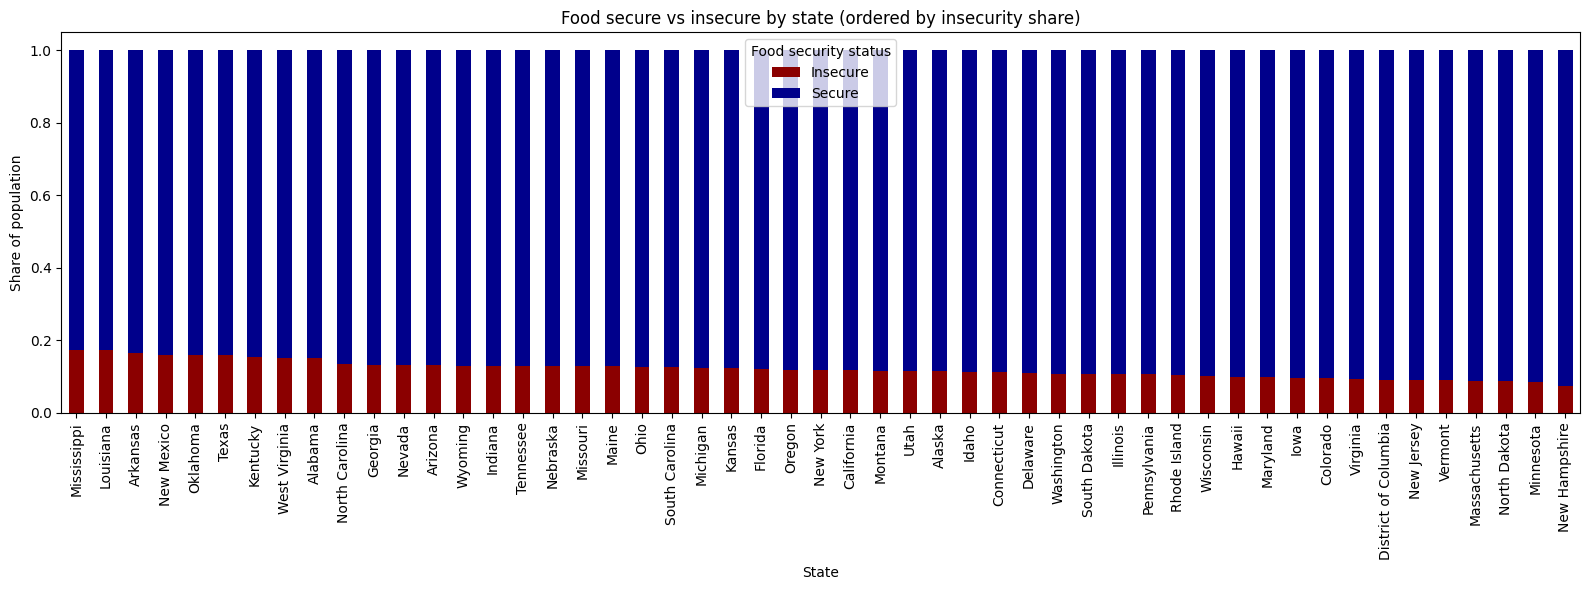

In [66]:
ax = props_sorted.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 6),
    color=["darkred", "darkblue"]  # Optional: green = secure, red = insecure
)

ax.set_xlabel("State")
ax.set_ylabel("Share of population")
ax.set_title("Food secure vs insecure by state (ordered by insecurity share)")

plt.xticks(rotation=90)
plt.legend(title="Food security status")

plt.tight_layout()
plt.show()


## State Food Security Map

In [67]:
name_to_abbr = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}


In [68]:
import plotly.express as px

df_plot = df_labeled.copy()

# Map FSSTATUS to Secure vs Insecure
status_map = {
    "Food secure": "Secure",
    "Low food secure": "Insecure",
    "Very low food secure": "Insecure"
}

df_plot["fs_binary"] = df_plot["FSSTATUS"].map(status_map)
df_plot = df_plot[df_plot["fs_binary"].notna()]


In [69]:
# STATEFIP currently has state label text
df_plot["state_name"] = df_plot["STATEFIP"]

# Keep only rows where we can map to a real state
df_plot = df_plot[df_plot["state_name"].isin(name_to_abbr.keys())]

df_plot["state_abbr"] = df_plot["state_name"].map(name_to_abbr)


In [156]:
state_counts_year = (
    df_plot
    .groupby(["YEAR", "state_abbr", "fs_binary"])
    .size()
    .unstack(fill_value=0)
)

state_props_year = state_counts_year.div(state_counts_year.sum(axis=1), axis=0)

state_map_df_year = (
    state_props_year[["Insecure"]]
    .reset_index()
    .rename(columns={"Insecure": "insecure_share"})
)


# Median insecure share per year across states
state_map_df_year["year_median"] = (
    state_map_df_year
    .groupby("YEAR")["insecure_share"]
    .transform("median")
)

# Difference from that year's median
state_map_df_year["diff_from_median"] = (
    state_map_df_year["insecure_share"] - state_map_df_year["year_median"]
)

# Use a symmetric range around zero for the color scale
max_abs = state_map_df_year["diff_from_median"].abs().max()


three_color_scale = [
    [0.0, "#006400"],  # dark green (well below median)
    [0.5, "#FFFFFF"],  # white (at median)
    [1.0, "#8B0000"]   # dark red (well above median)
]

import plotly.express as px

fig = px.choropleth(
    state_map_df_year,
    locations="state_abbr",
    locationmode="USA-states",
    color="diff_from_median",
    scope="usa",
    hover_name="state_abbr",
    animation_frame="YEAR",
    labels={"diff_from_median": "Difference from state median"}
)

# All traces share one coloraxis
for trace in fig.data:
    trace.update(coloraxis="coloraxis")

fig.update_layout(
    coloraxis=dict(
        cmin=-max_abs,
        cmax= max_abs,
        colorscale=three_color_scale,
        colorbar=dict(
            title="Diff from state median",
            ticks="outside"
        )
    ),
    title_text="Yearly median food insecurity by state (2014–2023)"
)

fig.show()


In [157]:
fig.write_html("state_plot.html", include_plotlyjs="cdn")

In [71]:
# Mean insecure share per year across states
state_map_df_year["year_mean"] = (
    state_map_df_year
    .groupby("YEAR")["insecure_share"]
    .transform("mean")
)

# Difference from that year's mean
state_map_df_year["diff_from_mean"] = (
    state_map_df_year["insecure_share"] - state_map_df_year["year_mean"]
)

three_color_scale = [
    [0.0, "#006400"],  # dark green (below mean)
    [0.5, "#FFFFFF"],  # white (at mean)
    [1.0, "#8B0000"]   # dark red (above mean)
]
max_abs = state_map_df_year["diff_from_mean"].abs().max()

fig = px.choropleth(
    state_map_df_year,
    locations="state_abbr",
    locationmode="USA-states",
    color="diff_from_mean",
    scope="usa",
    hover_name="state_abbr",
    animation_frame="YEAR",
    labels={"diff_from_mean": "Difference from yearly mean"},
)

for trace in fig.data:
    trace.update(coloraxis="coloraxis")

fig.update_layout(
    coloraxis=dict(
        cmin=-max_abs,
        cmax= max_abs,
        colorscale=three_color_scale,
        colorbar=dict(
            title="Difference from yearly mean",
            ticks="outside",
        )
    ),
    title_text="Deviation from yearly average food insecurity by state, CPS FSS 2014–2023"
)

fig.show()


In [72]:
# One row per state: median insecurity over all years in your dataset
state_median = (
    state_map_df_year
    .groupby("state_abbr")["insecure_share"]
    .median()
    .reset_index(name="insecure_median")
)

state_median.head()


,state_abbr,insecure_median
0,AK,0.105306
1,AL,0.139528
2,AR,0.166330
3,AZ,0.130987
4,CA,0.113614


In [73]:
state_median["insecure_median"].describe()


count    51.000000
mean      0.117088
std       0.023804
min       0.065491
25%       0.099879
50%       0.113809
75%       0.130369
max       0.173646
Name: insecure_median, dtype: float64

In [74]:
cmin = 0
cmax = 0.25   # or use state_median["insecure_median"].max()

In [75]:
import plotly.express as px

fig = px.choropleth(
    state_median,
    locations="state_abbr",
    locationmode="USA-states",
    color="insecure_median",
    scope="usa",
    hover_name="state_abbr",
    labels={"insecure_median": "Median share food insecure"},
)

fig.update_layout(
    coloraxis=dict(
        cmin=cmin,
        cmax=cmax,
        colorscale=three_color_scale,
        colorbar=dict(
            title="Median share food insecure",
            ticks="outside"
        )
    ),
    title_text="Median share of people in food insecure households by state, CPS FSS 2014-2023"
)

fig.show()

## Race

In [76]:
df_race = (
    df_labeled
    .groupby(["FSSTATUS", "RACE"])
    .size()
    .unstack(fill_value=0)
)

In [77]:
status_order = ["Food secure", "Low food secure", "Very low food secure"]

df_race = df_race.reindex(status_order)


<Figure size 1200x600 with 0 Axes>

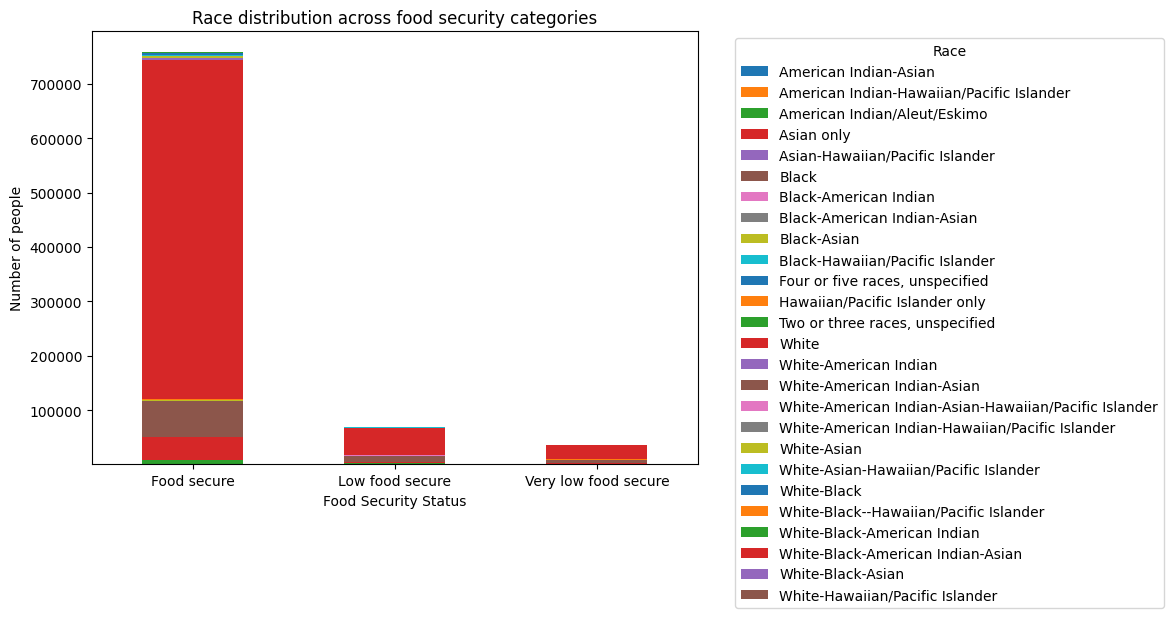

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

df_race.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6)
)

plt.xlabel("Food Security Status")
plt.ylabel("Number of people")
plt.title("Race distribution across food security categories")
plt.xticks(rotation=0)
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Combine Race Categories

In [79]:
df = df_labeled.copy()

def collapse_race(row):
    # Hispanic overrides all other categories
    if row["HISPAN"] != "Not Hispanic":
        return "Hispanic"
    
    race = row["RACE"]
    
    if race == "White":
        return "White"
    if race == "Black":
        return "Black"
    if "Asian" in race:
        return "Asian"
    
    return "Other"

df["race_group"] = df.apply(collapse_race, axis=1)


In [80]:
race_counts = (
    df.groupby(["FSSTATUS", "race_group"])
    .size()
    .unstack(fill_value=0)
)


In [81]:
race_pct = race_counts.div(race_counts.sum(axis=1), axis=0)


In [82]:
status_order = ["Food secure", "Low food secure", "Very low food secure"]
race_pct = race_pct.reindex(status_order)


In [83]:
ordering = (
    race_pct.loc["Food secure"]
    .sort_values(ascending=False)
    .index.tolist()
)

race_pct = race_pct[ordering]


<Figure size 1200x600 with 0 Axes>

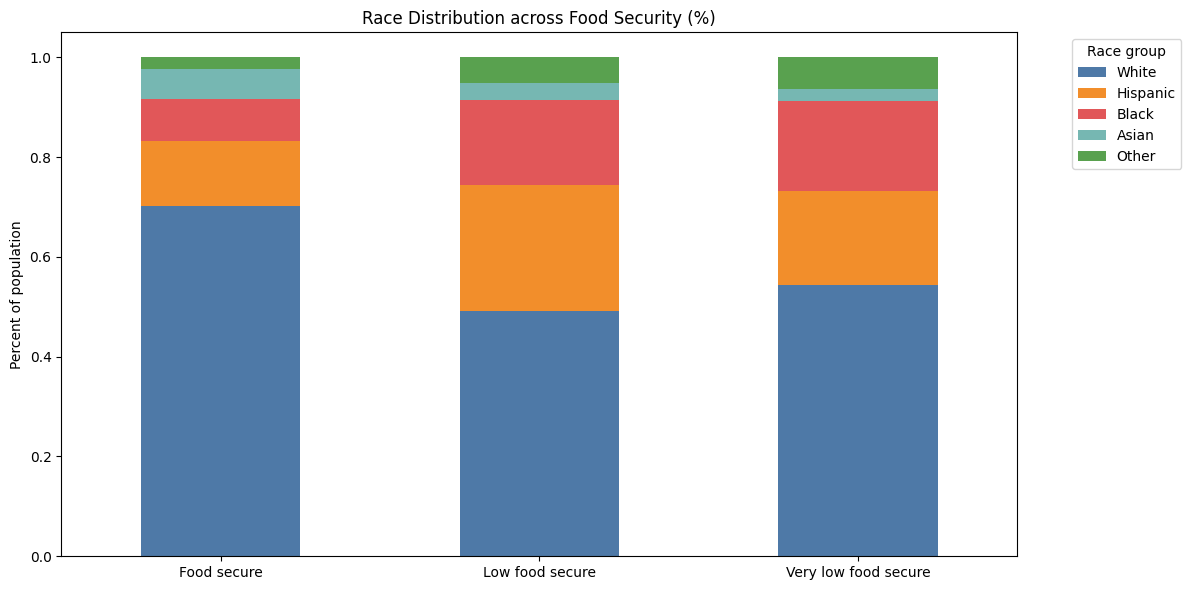

In [155]:
plt.figure(figsize=(12, 6))

tableau10 = [
    "#4E79A7",  # blue
    "#F28E2B",  # orange
    "#E15759",  # red
    "#76B7B2",  # teal
    "#59A14F",  # green
    "#EDC948",  # yellow
    "#B07AA1",  # purple
    "#FF9DA7",  # pink
    "#9C755F",  # brown
    "#BAB0AC"   # gray
]


race_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=tableau10    # or choose custom colors
)

plt.xlabel("")
plt.ylabel("Percent of population")
plt.title("Race Distribution across Food Security (%)")
plt.xticks(rotation=0)
plt.legend(title="Race group", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


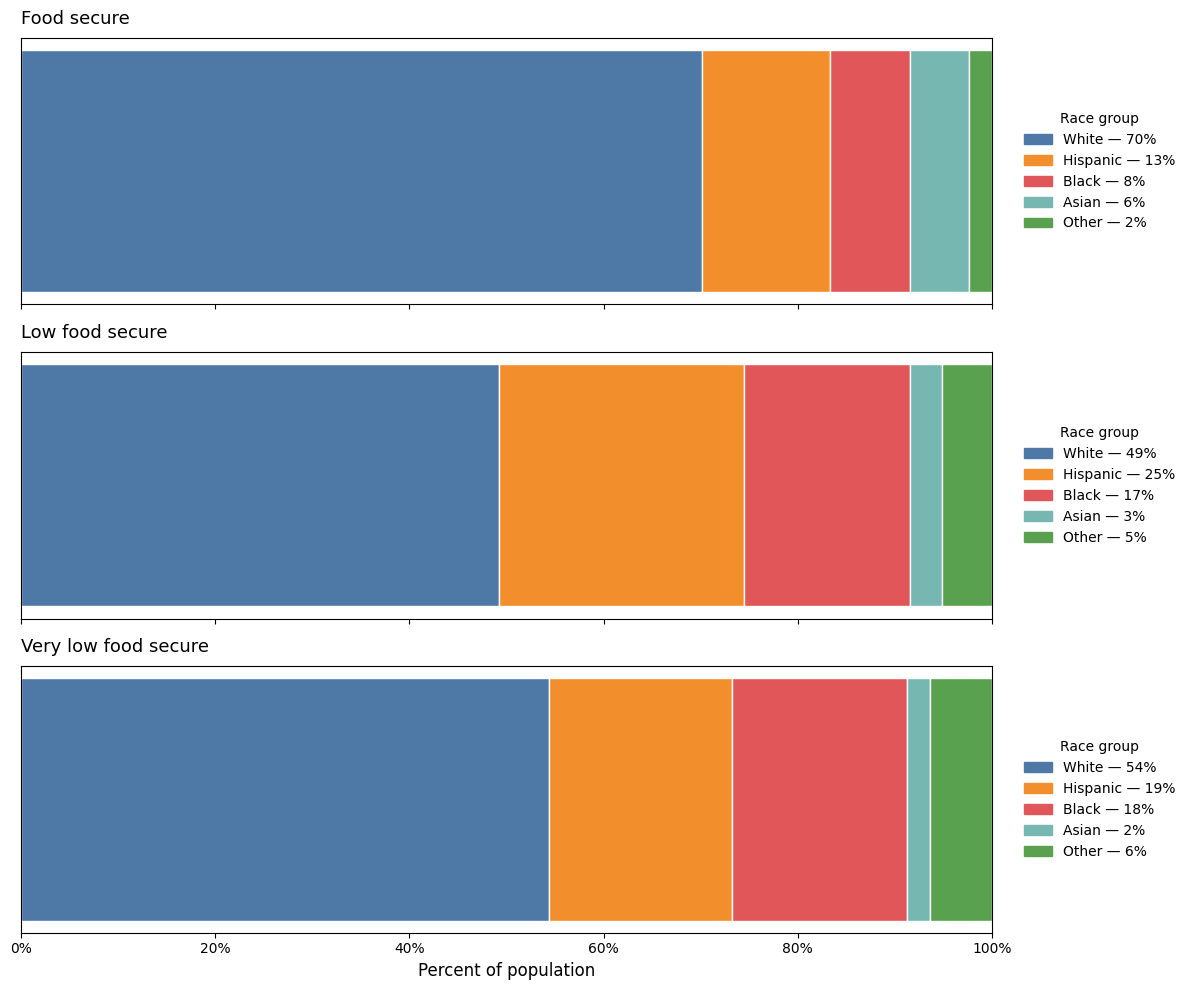

In [85]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Convert proportions to percentages
race_pct_percent = race_pct * 100

# FSSTATUS order
status_order = ["Food secure", "Low food secure", "Very low food secure"]

# Ensure correct row order
race_pct_percent = race_pct_percent.reindex(status_order)

# Colors using Tableau 10
colors = tableau10[:race_pct_percent.shape[1]]

fig, axes = plt.subplots(
    nrows=len(status_order),
    ncols=1,
    figsize=(12, 10),
    sharex=True
)

for ax, status in zip(axes, status_order):
    
    # Row data for this food security status
    row = race_pct_percent.loc[status]           # Series indexed by race_group
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar
    ax.barh(
        y=[0],
        width=row.values,
        left=cum_values.values,
        color=colors,
        edgecolor="white",
        height=0.5
    )
    
    # Axis formatting
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    ax.set_title(status, loc="left", fontsize=13, pad=10)
    
    # Legend labels specific to THIS FSSTATUS
    legend_labels = [f"{race} — {row[race]:.0f}%" for race in row.index]
    
    # Handles and legend for this subplot
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors[i])
        for i in range(len(row.index))
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="Race group",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

# X label only on bottom axis
axes[-1].set_xlabel("Percent of population", fontsize=12)

plt.tight_layout()
plt.show()


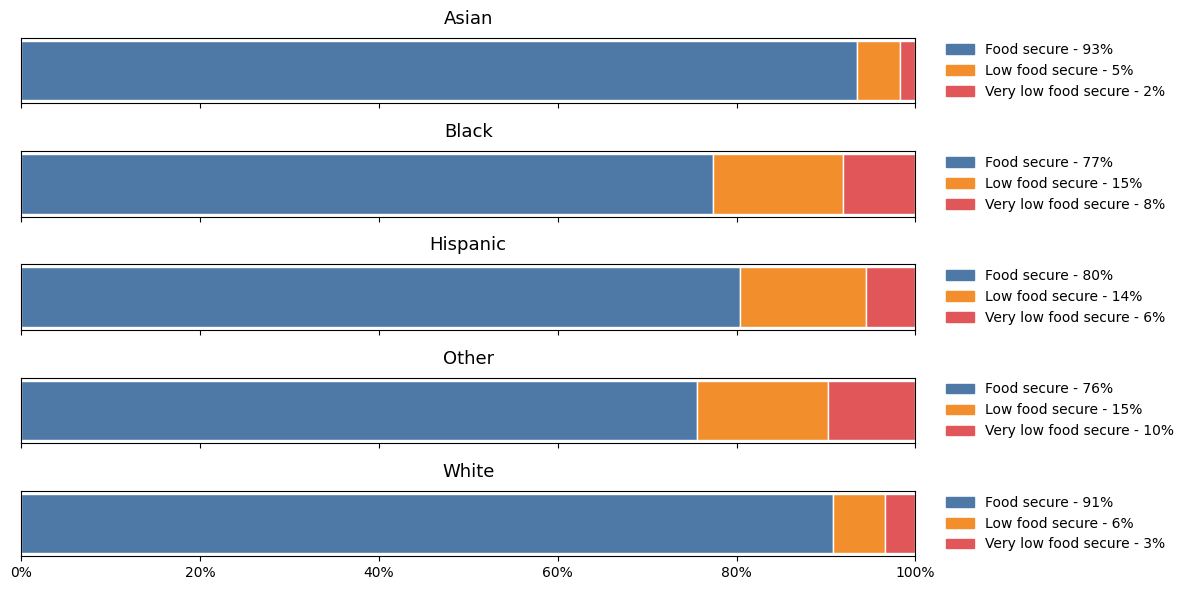

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------
# 1. Start from df_labeled (already loaded)
#    Assumes columns: FSSTATUS, RACE, HISPAN
# ------------------------------------------------

df = df_labeled.copy()

# Collapse RACE + HISPAN into 5 groups
def collapse_race(row):
    # Hispanic overrides race
    if row["HISPAN"] != "Not Hispanic":
        return "Hispanic"
    
    race = row["RACE"]
    
    if race == "White":
        return "White"
    if race == "Black":
        return "Black"
    if "Asian" in race:
        return "Asian"
    
    return "Other"

df["race_group"] = df.apply(collapse_race, axis=1)

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# ------------------------------------------------
# 2. Build race_group × FSSTATUS and normalize within race
# ------------------------------------------------

# Counts: race_group (rows) x FSSTATUS (columns)
race_fs_counts = (
    df.groupby(["race_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent column order
race_fs_counts = race_fs_counts[status_order]

# Convert to percentages within each race (rows sum to 100)
race_fs_pct = race_fs_counts.div(race_fs_counts.sum(axis=1), axis=0) * 100

# ------------------------------------------------
# 3. Define colors for food security statuses
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

race_groups = race_fs_pct.index.tolist()
fs_statuses = race_fs_pct.columns.tolist()

# ------------------------------------------------
# 4. Plot: one subplot per race_group, stacked by FSSTATUS
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(race_groups),
    ncols=1,
    figsize=(12, 6),
    sharex=True
)

for ax, race in zip(axes, race_groups):
    
    # Row data for this race: FSSTATUS percentages
    row = race_fs_pct.loc[race]      # Series indexed by FSSTATUS
    
    # For stacking, compute cumulative left positions
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar, segments by FSSTATUS
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors[status],
            edgecolor="white",
            height=0.5
        )
    
    # Axis formatting
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    
    # Title: race group on left
    ax.set_title(race, loc="center", fontsize=13, pad=10)
    
    # Legend labels specific to this race (these sum to ~100)
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]
    
    # Legend handles (matching colors)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors[status])
        for status in fs_statuses
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

# X label only on bottom axis
axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


## Sex Categories

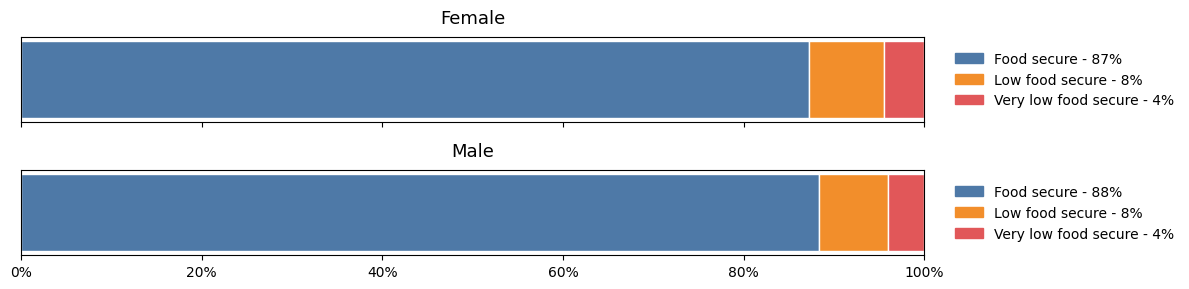

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------
# 1. Start from df_labeled (already loaded)
#    Assumes columns: FSSTATUS, SEX
# ------------------------------------------------

df = df_labeled.copy()

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# Keep only Male and Female
df = df[df["SEX"].isin(["Male", "Female"])]

# Rename for clarity (optional)
df["sex_group"] = df["SEX"]

# ------------------------------------------------
# 2. Build sex_group × FSSTATUS and normalize within sex
# ------------------------------------------------

# Counts: sex_group (rows) x FSSTATUS (columns)
sex_fs_counts = (
    df.groupby(["sex_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent column order
sex_fs_counts = sex_fs_counts[status_order]

# Convert to percentages within each sex (rows sum to 100)
sex_fs_pct = sex_fs_counts.div(sex_fs_counts.sum(axis=1), axis=0) * 100

# ------------------------------------------------
# 3. Define colors for food security statuses
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

sex_groups = sex_fs_pct.index.tolist()
fs_statuses = sex_fs_pct.columns.tolist()

# ------------------------------------------------
# 4. Plot: one subplot per sex_group, stacked by FSSTATUS
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(sex_groups),
    ncols=1,
    figsize=(12, 3),
    sharex=True
)

for ax, sex in zip(axes, sex_groups):
    
    # Row data for this sex: FSSTATUS percentages
    row = sex_fs_pct.loc[sex]      # Series indexed by FSSTATUS
    
    # For stacking, compute cumulative left positions
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar, segments by FSSTATUS
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors[status],
            edgecolor="white",
            height=0.5
        )
    
    # Axis formatting
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    
    # Title: sex group on left
    ax.set_title(sex, loc="center", fontsize=13, pad=10)
    
    # Legend labels specific to this sex (these sum to ~100)
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]
    
    # Legend handles (matching colors)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors[status])
        for status in fs_statuses
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

# X label only on bottom axis
axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


## Combine Education Categories

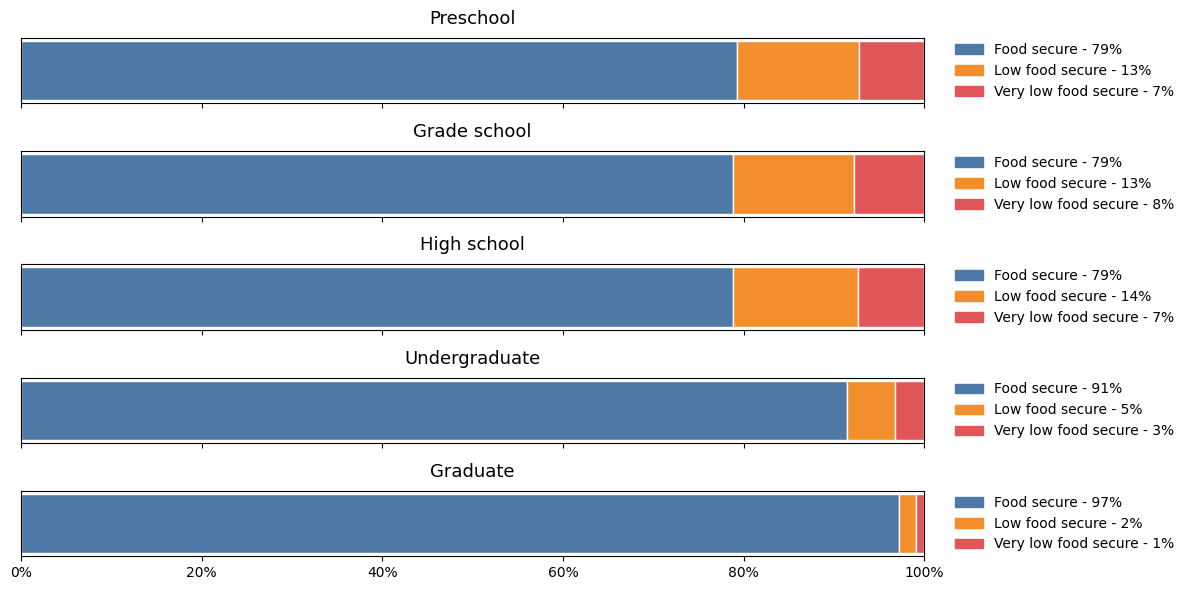

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------
# 1. Start from df_labeled
# ------------------------------------------------

df = df_labeled.copy()

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# ------------------------------------------------
# 2. Collapse EDUC into broad education groups
#    Updated: combine "Grade school" and "Elementary" into one category
# ------------------------------------------------

def collapse_educ(label):
    if not isinstance(label, str):
        return "Other"
    lbl = label.lower()
    
    # Preschool / no schooling
    if ("no schooling" in lbl or "nursery" in lbl 
        or "preschool" in lbl or "kindergarten" in lbl):
        return "Preschool"
    
    # Grade school (Grades 1 to 8 combined)
    if ("grade 1" in lbl or "grade 2" in lbl or "grade 3" in lbl or "grade 4" in lbl
        or "grade 5" in lbl or "grade 6" in lbl or "grade 7" in lbl or "grade 8" in lbl
        or "nursery school to grade 4" in lbl):
        return "Grade school"
    
    # High school (9 to 12, GED)
    if ("grade 9" in lbl or "grade 10" in lbl or "grade 11" in lbl):
        return "High school"
    if "12th grade" in lbl:
        return "High school"
    if "high school graduate" in lbl or "ged" in lbl:
        return "High school"
    
    # Undergraduate (some college, associate, bachelor)
    if "some college" in lbl or "college credit" in lbl:
        return "Undergraduate"
    if "associate" in lbl:
        return "Undergraduate"
    if "bachelor" in lbl:
        return "Undergraduate"
    
    # Graduate (masters, professional, doctorate)
    if "master" in lbl:
        return "Graduate"
    if "professional school" in lbl:
        return "Graduate"
    if "doctorate" in lbl or "phd" in lbl:
        return "Graduate"
    
    return "Other"

df["educ_group"] = df["EDUC"].apply(collapse_educ)

# Define order (updated)
educ_order = [
    "Preschool",
    "Grade school",      # now covers grades 1–8
    "High school",
    "Undergraduate",
    "Graduate"
]

# Keep only these 5
df = df[df["educ_group"].isin(educ_order)]

# ------------------------------------------------
# 3. Build educ_group × FSSTATUS and normalize within group
# ------------------------------------------------

educ_fs_counts = (
    df.groupby(["educ_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

educ_fs_counts = educ_fs_counts[status_order]

# Percent breakdown (rows sum to 100)
educ_fs_pct = educ_fs_counts.div(educ_fs_counts.sum(axis=1), axis=0) * 100

# Ensure correct order
educ_fs_pct = educ_fs_pct.reindex(educ_order)

# ------------------------------------------------
# 4. Colors for food security categories
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

educ_groups = educ_fs_pct.index.tolist()
fs_statuses = educ_fs_pct.columns.tolist()

# ------------------------------------------------
# 5. Plot: one subplot per education group
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(educ_groups),
    ncols=1,
    figsize=(12, 6),
    sharex=True
)

for ax, educ in zip(axes, educ_groups):
    
    row = educ_fs_pct.loc[educ]
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors[status],
            edgecolor="white",
            height=0.5
        )
    
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    
    ax.set_title(educ, loc="center", fontsize=13, pad=10)
    
    # Legend: per education group percentages
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]
    
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors[status])
        for status in fs_statuses
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


## Marital Status

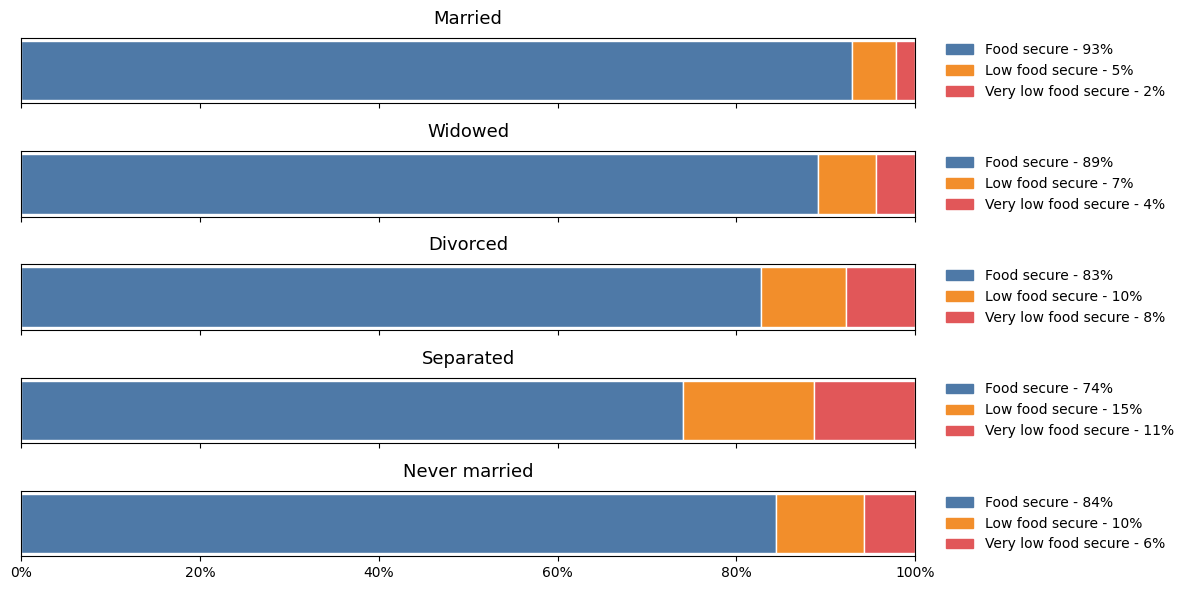

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------
# 1. Start from df_labeled
#    Assumes columns: FSSTATUS, MARST
# ------------------------------------------------

df = df_labeled.copy()

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# ------------------------------------------------
# 2. Collapse MARST into broad marital status groups
# ------------------------------------------------

def collapse_marital(label):
    if not isinstance(label, str):
        return "Other"
    lbl = label.lower()
    
    # Never married or single
    if "never married" in lbl or "single" in lbl:
        return "Never married"
    
    # Married but not separated
    if "married" in lbl and "separated" not in lbl:
        return "Married"
    
    # Separated
    if "separated" in lbl:
        return "Separated"
    
    # Divorced
    if "divorced" in lbl:
        return "Divorced"
    
    # Widowed
    if "widowed" in lbl:
        return "Widowed"
    
    return "Other"

df["mar_group"] = df["MARST"].apply(collapse_marital)

# Define the order of marital groups we care about
mar_order = ["Married", "Widowed", "Divorced", "Separated", "Never married"]

# Keep only those groups
df = df[df["mar_group"].isin(mar_order)]

# ------------------------------------------------
# 3. Build mar_group x FSSTATUS and normalize within mar_group
# ------------------------------------------------

# Counts: mar_group (rows) x FSSTATUS (columns)
mar_fs_counts = (
    df.groupby(["mar_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent FSSTATUS order
mar_fs_counts = mar_fs_counts[status_order]

# Convert to percentages within each marital group (rows sum to 100)
mar_fs_pct = mar_fs_counts.div(mar_fs_counts.sum(axis=1), axis=0) * 100

# Ensure marital group row order
mar_fs_pct = mar_fs_pct.reindex(mar_order)

# ------------------------------------------------
# 4. Define colors for food security statuses
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

mar_groups = mar_fs_pct.index.tolist()
fs_statuses = mar_fs_pct.columns.tolist()

# ------------------------------------------------
# 5. Plot - one subplot per marital group, stacked by FSSTATUS
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(mar_groups),
    ncols=1,
    figsize=(12, 6),
    sharex=True
)

for ax, mar in zip(axes, mar_groups):
    
    # Row data for this marital group: FSSTATUS percentages
    row = mar_fs_pct.loc[mar]      # Series indexed by FSSTATUS
    
    # For stacking, compute cumulative left positions
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar, segments by FSSTATUS
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors[status],
            edgecolor="white",
            height=0.5
        )
    
    # Axis formatting
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    
    # Title: marital group on left
    ax.set_title(mar, loc="center", fontsize=13, pad=10)
    
    # Legend labels specific to this marital group
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]
    
    # Legend handles (matching colors)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors[status])
        for status in fs_statuses
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

# X label only on bottom axis
axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


## Income

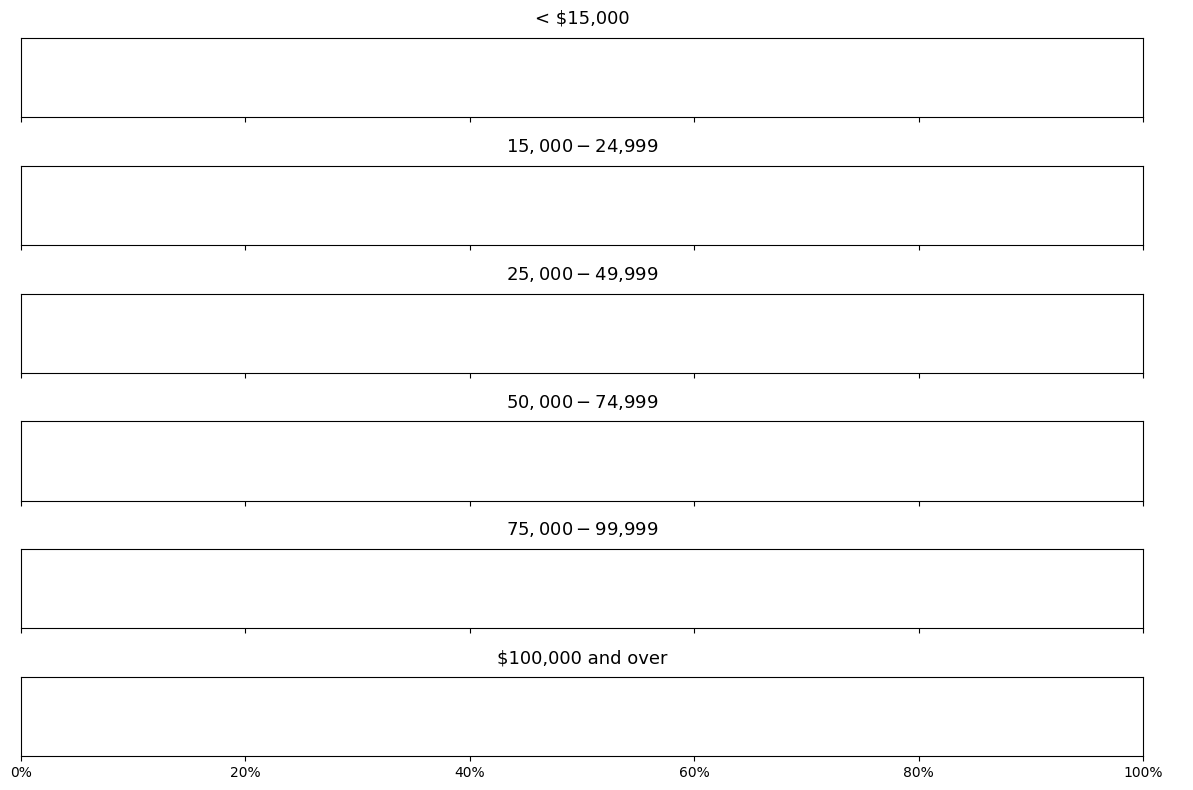

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------
# 1. Start from df_labeled
#    Assumes columns: FSSTATUS, FAMINC
# ------------------------------------------------

df = df_labeled.copy()

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# ------------------------------------------------
# 2. Collapse FAMINC into broad income groups (max 6)
# ------------------------------------------------

def collapse_faminc(code):
    if pd.isna(code):
        return None
    try:
        c = int(code)
    except ValueError:
        return None

    # Missing / refused / do not know / blank
    if c in [995, 996, 997, 999]:
        return None

    if c < 500:
        return "< $15,000"
    elif 500 <= c < 700:
        return "$15,000 - $24,999"
    elif 700 <= c < 800:
        return "$25,000 - $49,999"
    elif 800 <= c < 840:
        return "$50,000 - $74,999"
    elif c in [840, 841]:
        return "$75,000 - $99,999"
    elif c in [842, 843]:
        return "$100,000 and over"
    else:
        return None

df["inc_group"] = df["FAMINC"].apply(collapse_faminc)

# Keep only non missing groups
df = df[df["inc_group"].notna()]

# Define the order of income groups
inc_order = [
    "< $15,000",
    "$15,000 - $24,999",
    "$25,000 - $49,999",
    "$50,000 - $74,999",
    "$75,000 - $99,999",
    "$100,000 and over"
]

# ------------------------------------------------
# 3. Build inc_group x FSSTATUS and normalize within inc_group
# ------------------------------------------------

# Counts: inc_group (rows) x FSSTATUS (columns)
inc_fs_counts = (
    df.groupby(["inc_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

# Only keep status columns that actually exist, in desired order
available_status = [s for s in status_order if s in inc_fs_counts.columns]
inc_fs_counts = inc_fs_counts[available_status]

# Convert to percentages within each income group (rows sum to 100)
inc_fs_pct = inc_fs_counts.div(inc_fs_counts.sum(axis=1), axis=0) * 100

# Ensure income group row order
inc_fs_pct = inc_fs_pct.reindex(inc_order)

# ------------------------------------------------
# 4. Define colors for food security statuses
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

inc_groups = inc_fs_pct.index.tolist()
fs_statuses = inc_fs_pct.columns.tolist()

# ------------------------------------------------
# 5. Plot - one subplot per income group, stacked by FSSTATUS
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(inc_groups),
    ncols=1,
    figsize=(12, 8),
    sharex=True
)

for ax, inc in zip(axes, inc_groups):

    # Some income groups might be all NaN if no rows
    if inc not in inc_fs_pct.index:
        ax.axis("off")
        continue

    # Row data for this income group: FSSTATUS percentages
    row = inc_fs_pct.loc[inc]

    # For stacking, compute cumulative left positions
    cum_values = row.cumsum().shift(fill_value=0)

    # Horizontal stacked bar, segments by FSSTATUS
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors.get(status, "#cccccc"),
            edgecolor="white",
            height=0.5
        )

    # Axis formatting
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])

    # Title: income group centered
    ax.set_title(inc, loc="center", fontsize=13, pad=10)

    # Legend labels specific to this income group
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]

    # Legend handles (matching colors)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors.get(status, "#cccccc"))
        for status in fs_statuses
    ]

    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

# X label only on bottom axis
axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


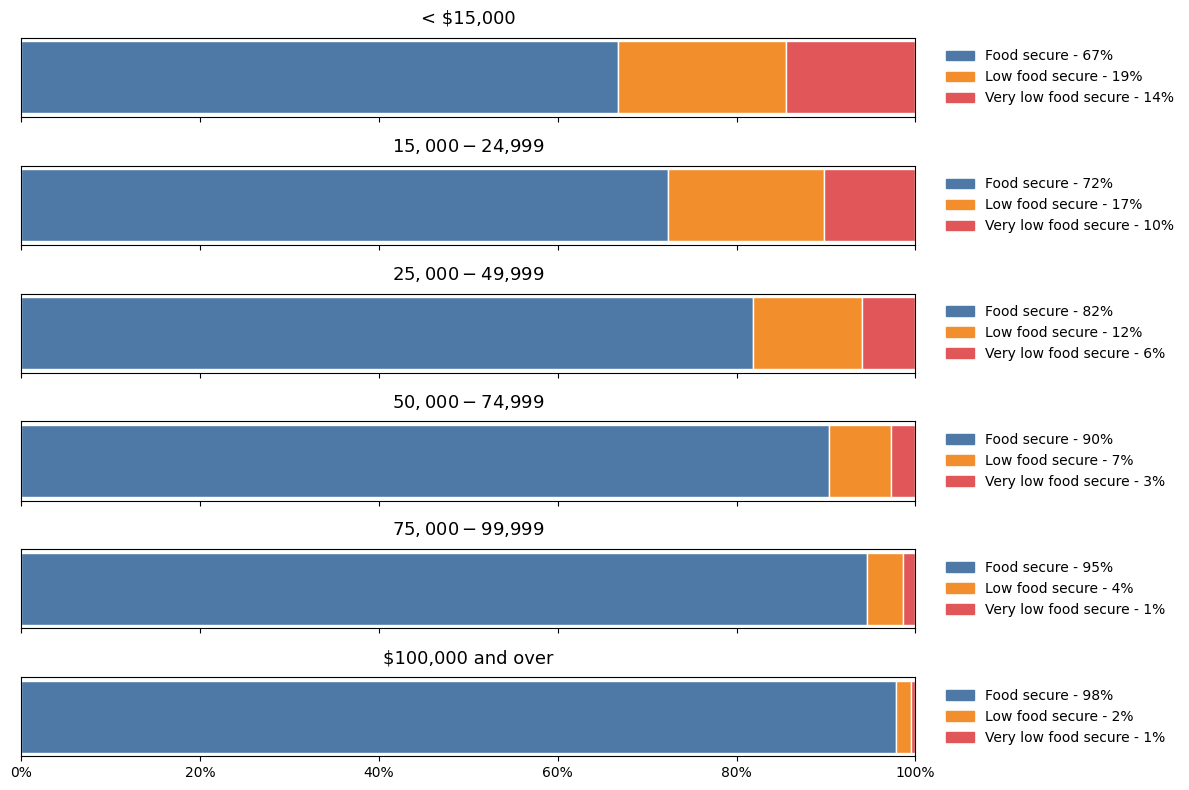

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import re

# ------------------------------------------------
# 1. Start from df_labeled
#    Assumes columns: FSSTATUS, FAMINC (text labels)
# ------------------------------------------------

df = df_labeled.copy()

# Keep only the FSSTATUS categories you care about
status_order = ["Food secure", "Low food secure", "Very low food secure"]
df = df[df["FSSTATUS"].isin(status_order)]

# ------------------------------------------------
# 2. Collapse FAMINC (label text) into broad income groups
# ------------------------------------------------

def parse_income_range(label):
    """
    Parse a FAMINC label string like:
      'Under $5,000'
      '$10,000 - 14,999'
      '$50,000 and over'
    into approximate (lower, upper) numeric bounds.
    upper can be None for 'and over' cases.
    """
    if not isinstance(label, str):
        return None, None
    
    # Extract all numbers in the string
    nums = re.findall(r"\$?([\d,]+)", label)
    if not nums:
        return None, None
    
    # Convert to ints
    vals = [int(n.replace(",", "")) for n in nums]
    
    lbl = label.lower()
    
    if "under" in lbl:
        # 'Under $5,000' -> (0, 5000)
        lower = 0
        upper = vals[0]
    elif "and over" in lbl:
        # '$50,000 and over' -> (50000, inf)
        lower = vals[0]
        upper = None
    elif "-" in lbl:
        # '$10,000 - 14,999' -> (10000, 14999)
        lower = vals[0]
        upper = vals[1]
    else:
        # Fallback: treat as a point or lower bound
        lower = vals[0]
        upper = None
    
    return lower, upper

def collapse_faminc_from_label(label):
    if not isinstance(label, str):
        return None
    
    lower, upper = parse_income_range(label)
    if lower is None and upper is None:
        return None
    
    # Define bins using the lower bound
    # You can tweak these thresholds if you want different cut points
    if upper is not None and upper <= 15000:
        return "< $15,000"
    if lower < 15000:
        return "< $15,000"
    elif 15000 <= lower < 25000:
        return "$15,000 - $24,999"
    elif 25000 <= lower < 50000:
        return "$25,000 - $49,999"
    elif 50000 <= lower < 75000:
        return "$50,000 - $74,999"
    elif 75000 <= lower < 100000:
        return "$75,000 - $99,999"
    elif lower >= 100000:
        return "$100,000 and over"
    
    return None

df["inc_group"] = df["FAMINC"].apply(collapse_faminc_from_label)

# Keep only non missing groups
df = df[df["inc_group"].notna()]

# Define the order of income groups
inc_order = [
    "< $15,000",
    "$15,000 - $24,999",
    "$25,000 - $49,999",
    "$50,000 - $74,999",
    "$75,000 - $99,999",
    "$100,000 and over"
]

# ------------------------------------------------
# 3. Build inc_group x FSSTATUS and normalize within inc_group
# ------------------------------------------------

inc_fs_counts = (
    df.groupby(["inc_group", "FSSTATUS"])
    .size()
    .unstack(fill_value=0)
)

# Only keep status columns that exist, in desired order
available_status = [s for s in status_order if s in inc_fs_counts.columns]
inc_fs_counts = inc_fs_counts[available_status]

# Convert to percentages within each income group
inc_fs_pct = inc_fs_counts.div(inc_fs_counts.sum(axis=1), axis=0) * 100

# Ensure income group row order
inc_fs_pct = inc_fs_pct.reindex(inc_order)

# ------------------------------------------------
# 4. Define colors for food security statuses
# ------------------------------------------------

fs_colors = {
    "Food secure": "#4E79A7",         # blue
    "Low food secure": "#F28E2B",     # orange
    "Very low food secure": "#E15759" # red
}

inc_groups = inc_fs_pct.index.tolist()
fs_statuses = inc_fs_pct.columns.tolist()

# ------------------------------------------------
# 5. Plot - one subplot per income group, stacked by FSSTATUS
# ------------------------------------------------

fig, axes = plt.subplots(
    nrows=len(inc_groups),
    ncols=1,
    figsize=(12, 8),
    sharex=True
)

for ax, inc in zip(axes, inc_groups):
    
    # Skip groups that might be all missing
    if inc not in inc_fs_pct.index:
        ax.axis("off")
        continue
    
    # Row data for this income group
    row = inc_fs_pct.loc[inc]
    cum_values = row.cumsum().shift(fill_value=0)
    
    # Horizontal stacked bar
    for status in fs_statuses:
        ax.barh(
            y=[0],
            width=row[status],
            left=cum_values[status],
            color=fs_colors.get(status, "#cccccc"),
            edgecolor="white",
            height=0.5
        )
    
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_yticks([])
    
    ax.set_title(inc, loc="center", fontsize=13, pad=10)
    
    # Legend labels per income group
    legend_labels = [f"{status} - {row[status]:.0f}%" for status in fs_statuses]
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=fs_colors.get(status, "#cccccc"))
        for status in fs_statuses
    ]
    
    ax.legend(
        handles,
        legend_labels,
        title="",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

axes[-1].set_xlabel("", fontsize=12)

plt.tight_layout()
plt.show()


/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_43798/208579933.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



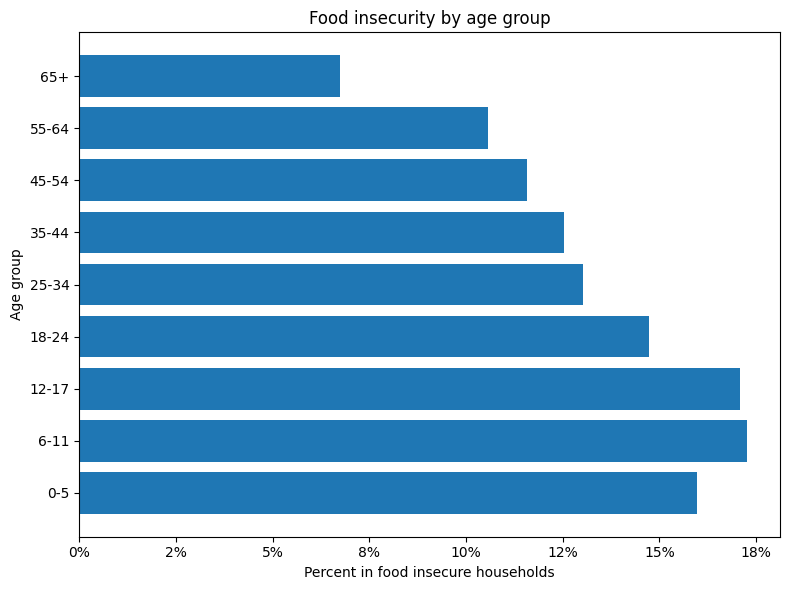

In [102]:
df = df_labeled.copy()

# 1. FIX: Ensure AGE is numeric
df["AGE"] = pd.to_numeric(df["AGE"], errors="coerce")

# Remove rows with missing AGE
df = df[df["AGE"].notna()]

# Map FSSTATUS into Secure / Insecure
status_map = {
    "Food secure": "Secure",
    "Low food secure": "Insecure",
    "Very low food secure": "Insecure"
}
df["fs_binary"] = df["FSSTATUS"].map(status_map)
df = df[df["fs_binary"].notna()]

# Age bins
bins = [0, 5, 11, 17, 24, 34, 44, 54, 64, 200]
labels = ["0-5","6-11","12-17","18-24","25-34","35-44","45-54","55-64","65+"]

df["age_group"] = pd.cut(
    df["AGE"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Percent insecure by age group
age_counts = (
    df.groupby(["age_group", "fs_binary"])
    .size()
    .unstack(fill_value=0)
)

age_pct = age_counts.div(age_counts.sum(axis=1), axis=0) * 100

# Plot
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,6))
plt.barh(
    age_pct.index,
    age_pct["Insecure"]
)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
plt.xlabel("Percent in food insecure households")
plt.ylabel("Age group")
plt.title("Food insecurity by age group")
plt.tight_layout()
plt.show()


/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_43798/3061010794.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



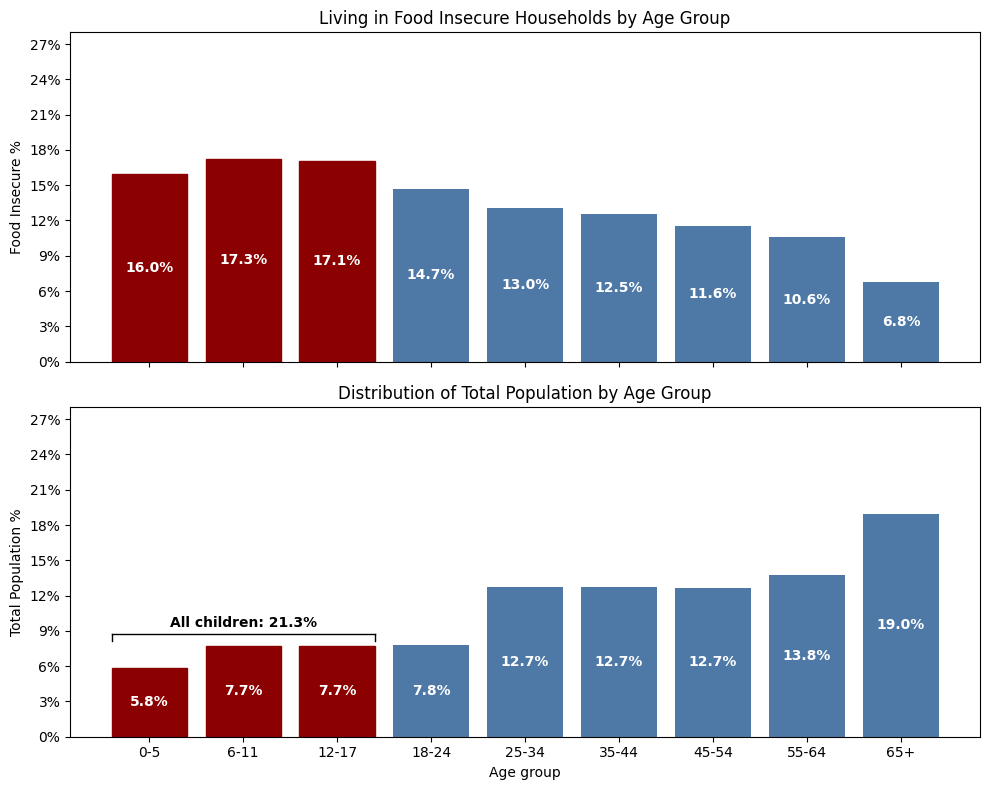

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator

# ----------------------------------------
# 1. Prep data and age groups
# ----------------------------------------
df = df_labeled.copy()

df["AGE"] = pd.to_numeric(df["AGE"], errors="coerce")
df = df[df["AGE"].notna()]

bins = [0, 5, 11, 17, 24, 34, 44, 54, 64, 200]
labels = ["0-5","6-11","12-17","18-24","25-34","35-44","45-54","55-64","65+"]

df["age_group"] = pd.cut(
    df["AGE"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

status_map = {
    "Food secure": "Secure",
    "Low food secure": "Insecure",
    "Very low food secure": "Insecure"
}

df["fs_binary"] = df["FSSTATUS"].map(status_map)
df = df[df["fs_binary"].notna()]

# ----------------------------------------
# 2. Food insecurity percent by age group
# ----------------------------------------
age_counts = (
    df.groupby(["age_group", "fs_binary"])
    .size()
    .unstack(fill_value=0)
)

age_pct = age_counts.div(age_counts.sum(axis=1), axis=0) * 100
insecure_pct = age_pct["Insecure"].reindex(labels)

# ----------------------------------------
# 3. Population share by age group
# ----------------------------------------
age_pop_counts = df["age_group"].value_counts().reindex(labels)
age_pop_pct = age_pop_counts / age_pop_counts.sum() * 100

child_idx = [0, 1, 2]  # 0-5, 6-11, 12-17

# ----------------------------------------
# 4. Two panel layout
# ----------------------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True
)

blue = "#4E79A7"
dark_red = "#8B0000"
y_max = 28
tick_step = 3

# -----------------------
# Top panel (NO bracket/annotation)
# -----------------------
bars = axes[0].bar(labels, insecure_pct.values, color=blue)

for i in child_idx:
    bars[i].set_color(dark_red)

axes[0].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
axes[0].yaxis.set_major_locator(MultipleLocator(tick_step))
axes[0].set_ylim(0, y_max)

axes[0].set_ylabel("Food Insecure %")
axes[0].set_title("Living in Food Insecure Households by Age Group")

# White centered labels
for bar in bars:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.1f}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------
# Bottom panel (WITH bracket + annotation)
# -----------------------
bars2 = axes[1].bar(labels, age_pop_pct.values, color=blue)

for i in child_idx:
    bars2[i].set_color(dark_red)

axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
axes[1].yaxis.set_major_locator(MultipleLocator(tick_step))
axes[1].set_ylim(0, y_max)

axes[1].set_ylabel("Total Population %")
axes[1].set_xlabel("Age group")
axes[1].set_title("Distribution of Total Population by Age Group")

# White centered labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.1f}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

# --- Bracket + annotation only on bottom panel ---
child_total = age_pop_pct.iloc[0:3].sum()

left_bar = bars2[child_idx[0]]
right_bar = bars2[child_idx[-1]]

left_x = left_bar.get_x()
right_x = right_bar.get_x() + right_bar.get_width()

# LOWER the bracket (choose height relative to actual child bars)
child_max_height = max([bars2[i].get_height() for i in child_idx])

bracket_y = child_max_height + 1.0   # <<< moved lower
hook = 0.6                           # shorter hooks for aesthetics

# Horizontal line
axes[1].plot([left_x, right_x], [bracket_y, bracket_y], color="black", linewidth=1)

# Hooks
axes[1].plot([left_x, left_x], [bracket_y, bracket_y - hook], color="black", linewidth=1)
axes[1].plot([right_x, right_x], [bracket_y, bracket_y - hook], color="black", linewidth=1)

# Annotation (also moved lower)
x_center = (left_x + right_x) / 2
axes[1].text(
    x_center,
    bracket_y + 0.3,                 # <<< lowered offset
    f"All children: {child_total:.1f}%",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
    color="black"
)


plt.tight_layout()
plt.show()


   poverty_level   n_obs  insecure_pct  very_low_pct  poverty_pct
0              1   75546     33.269796     14.487862     8.740311
1              2   66278     27.709044     10.274903     7.668047
2              3  192234     18.158078      5.921949    22.240553
3              4  159402      9.714433      2.767217    18.442048
4              5  113986      5.375222      1.405436    13.187634
5              6  256894      2.193122      0.536019    29.721406


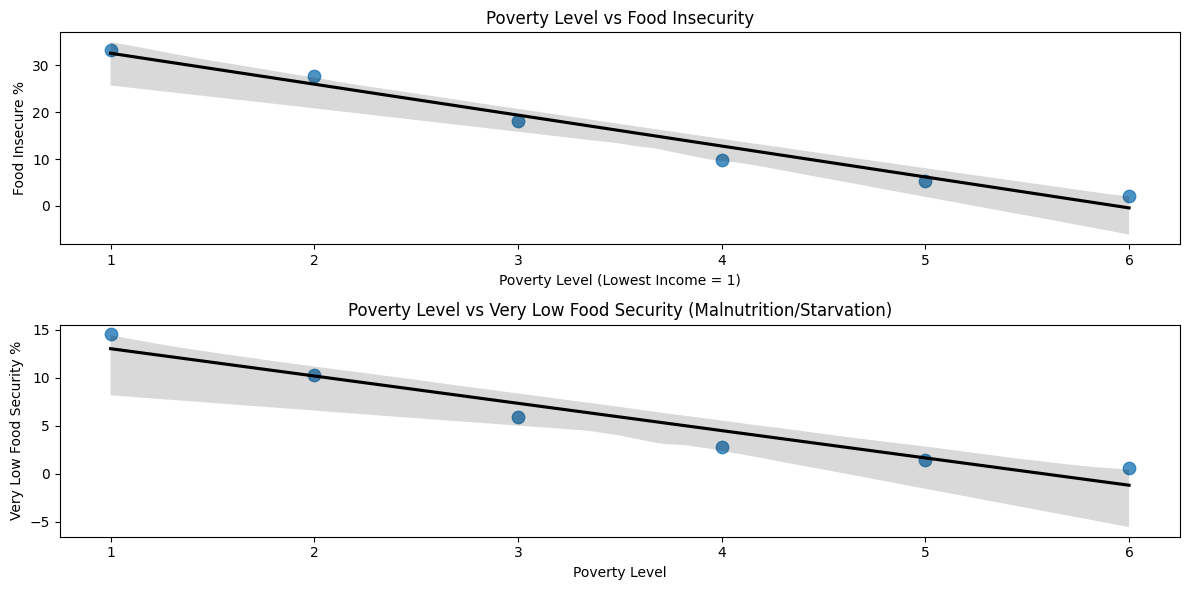

In [149]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Create poverty_level from FAMINC string
# ------------------------------------------------
def poverty_level_from_faminc(label):
    if not isinstance(label, str):
        return None

    # Extract all numeric tokens
    amounts = re.findall(r"\$?([\d,]+)", label)
    if not amounts:
        return None

    vals = [int(x.replace(",", "")) for x in amounts]
    lower = min(vals)  # use lower bound of the range

    # Bin by lower bound
    if lower < 15000:
        return 1    # highest poverty
    elif lower < 25000:
        return 2
    elif lower < 50000:
        return 3
    elif lower < 75000:
        return 4
    elif lower < 100000:
        return 5
    else:
        return 6    # lowest poverty

df = df_labeled.copy()
df["poverty_level"] = df["FAMINC"].apply(poverty_level_from_faminc)

# Filter out missing poverty_level
df = df[df["poverty_level"].notna()]

# ------------------------------------------------
# 2. Build food insecurity measures
# ------------------------------------------------
# Binary insecure vs secure
fs_binary_map = {
    "Food secure": 0,
    "Low food secure": 1,
    "Very low food secure": 1
}
df["insecure_flag"] = df["FSSTATUS"].map(fs_binary_map)

# Very low FS flag (as proxy for hunger or most severe)
df["very_low_flag"] = (df["FSSTATUS"] == "Very low food secure").astype(int)

# Keep rows with valid FSSTATUS mapping
df = df[df["insecure_flag"].notna()]

# ------------------------------------------------
# 3. Aggregate to poverty_level and build corr_df
# ------------------------------------------------
grouped = df.groupby("poverty_level", dropna=True)

corr_df = grouped.agg(
    n_obs         = ("FSSTATUS", "size"),
    insecure_pct  = ("insecure_flag", lambda x: x.mean() * 100),
    very_low_pct  = ("very_low_flag", lambda x: x.mean() * 100)
).reset_index()   # <-- this makes poverty_level a column

# Share of population in each poverty_level
corr_df["poverty_pct"] = corr_df["n_obs"] / corr_df["n_obs"].sum() * 100

# Check what we have
print(corr_df)

# ------------------------------------------------
# 4. Correlation plots
# ------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.regplot(
    data=corr_df,
    x="poverty_level",
    y="insecure_pct",
    ax=axes[0],
    scatter_kws={"s": 80},
    line_kws={"color": "black"}
)
axes[0].set_title("Poverty Level vs Food Insecurity")
axes[0].set_xlabel("Poverty Level (Lowest Income = 1)")
axes[0].set_ylabel("Food Insecure %")

sns.regplot(
    data=corr_df,
    x="poverty_level",
    y="very_low_pct",
    ax=axes[1],
    scatter_kws={"s": 80},
    line_kws={"color": "black"}
)
axes[1].set_title("Poverty Level vs Very Low Food Security (Malnutrition/Starvation)")
axes[1].set_xlabel("Poverty Level")
axes[1].set_ylabel("Very Low Food Security %")



plt.tight_layout()
plt.show()


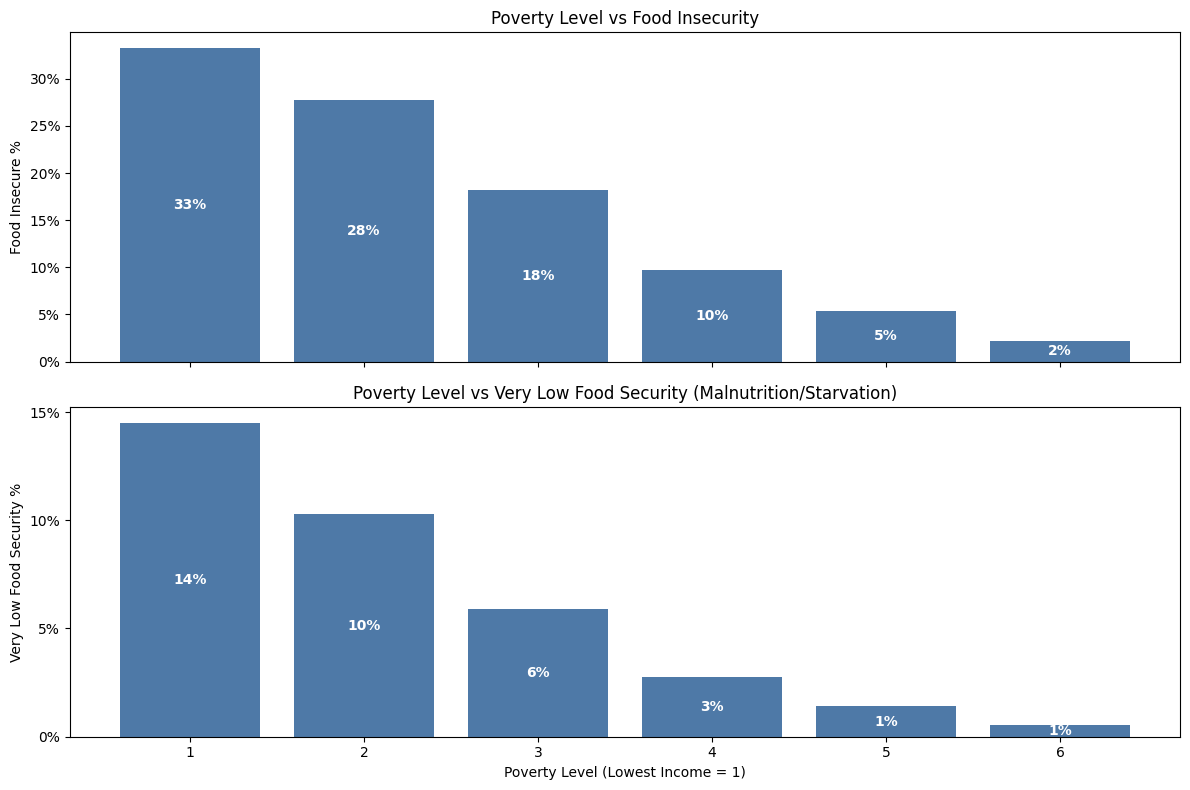

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator

# ------------------------------------------------
# 4. Bar plots with shared x axis
# ------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# -------------------------
# Top panel: Food Insecurity
# -------------------------
bars1 = axes[0].bar(
    corr_df["poverty_level"],
    corr_df["insecure_pct"],
    color="#4E79A7"
)

axes[0].set_title("Poverty Level vs Food Insecurity")
axes[0].set_ylabel("Food Insecure %")
axes[0].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
axes[0].yaxis.set_major_locator(MultipleLocator(5))

# Add white centered labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        height/2,
        f"{height:.0f}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

# -------------------------
# Bottom panel: Very Low Food Security
# -------------------------
bars2 = axes[1].bar(
    corr_df["poverty_level"],
    corr_df["very_low_pct"],
    color="#4E79A7"
)

axes[1].set_title("Poverty Level vs Very Low Food Security (Malnutrition/Starvation)")
axes[1].set_xlabel("Poverty Level (Lowest Income = 1)")
axes[1].set_ylabel("Very Low Food Security %")
axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
axes[1].yaxis.set_major_locator(MultipleLocator(5))

# Add white centered labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        height/2,
        f"{height:.0f}%",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()
